In [2]:
import json
import csv
import math
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import spatial
from numpy.linalg import svd

In [3]:
x, y = [], []
genre = []
lang = []
with open('movies.csv','r') as csvfile:
	plot = csv.reader(csvfile,delimiter=',')
	for row in plot:
		x.append(row[9])
		y.append(row[4])
		genre.append(row[8])
		lang.append(row[2])
with open('finalset.csv','r') as csvf:
	pl = csv.reader(csvf,delimiter=',')
	for row in pl:
		x.append(row[5])
		y.append(row[2])
		genre.append(row[4])
		lang.append(row[1])
# 2851 movies, 2851 users, 2851 ratings; movies.csv
data={'Movies':x,'Ratings':y}
df=pd.DataFrame(data)
# 919 users; 10,000 ratings; users.csv
language,gender,state,job=[],[],[],[]
age=[]
with open('users.csv','r') as cf:
	p=csv.reader(cf,delimiter=',')
	for row in p:
		language.append(row[1])
		gender.append(row[5])
		age.append(row[4][6:])
		state.append(row[3])

In [4]:
R = np.array([
	
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
	
	])
	
user,item=R.shape
alpha,beta,iterations=0.1,0.01,20 #alpha is a learning parameter, beta is for regularization. as iterations increase, a more fine tuned recomm. is obtained
K=2 #no. of dimensions

def full_matrix(b,b_u,b_i,P,Q): #returns PxQ
	return b+b_u[:,np.newaxis] + b_i[np.newaxis:,] + P.dot(Q.T)

def get_rating(i,j,b,b_u,b_i,P,Q): #returns rating
	return b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)

def sgd(P,Q,samples,b,b_u,b_i):
	global alpha
	global beta
	for i,j,r in samples:
		prediction = get_rating(i,j,b,b_u,b_i,P,Q)
		e=(r-prediction)

		b_u[i]+= alpha*(e- beta*b_u[i])
		b_i[j]+= alpha*(e- beta*b_i[j])

		P[i, :] += alpha * (e*Q[j, :] - beta*P[i, :])
		Q[j, :] += alpha * (e*P[i, :] - beta*Q[j, :])

def mse(R,b,b_u,b_i,P,Q):
	xs,ys=R.nonzero()
	predicted = full_matrix(b,b_u,b_i,P,Q); 
	error = 0;
	for x,y in zip(xs,ys):
		error+= (R[x,y]-predicted[x,y]) ** 2
		#print "Square error : ",error
	return np.sqrt(error)

def train(R,user,item,K,iterations):
	P=np.random.normal(scale=1./K, size=(user,K))
	Q=np.random.normal(scale=1./K, size=(item,K))
	#b_u = user bias, b_i = item bias, b= bias. Bias is set on mean, where R!=0
	b_u=np.zeros(user)
	b_i=np.zeros(item)
	b=np.mean(R[np.where(R != 0)])
	samples=[
				(i,j,R[i,j])
				for i in range(user)
				for j in range(item)
				if R[i,j]>0
			]
	training_process = []
	for i in range(iterations):
		np.random.shuffle(samples)
		sgd(P,Q,samples,b,b_u,b_i) #stochastic gradient descent
		mean_sq_error=mse(R,b,b_u,b_i,P,Q)   #mean square error
		training_process.append((i,mean_sq_error))
		if (i+1)%10 == 0:
			print ("Iteration : ",i+1," error : ",mean_sq_error)
	#print "\nFactorized Matrix : \n"
	return training_process, full_matrix(b,b_u,b_i,P,Q)
def normalize(fact_mat,scale):
	biggest , smallest = -float('inf') , float('inf');
	print ("\nFactorized Matrix : \n")
	for row in fact_mat:
		for item in row:
			print ("%1.5f "%(item),end=" ")
		print (" ")
	new_list = [] #1D array. 0(n) to print , make , evaluate.
	#Find biggest element in the matrix. Since review scale is based on 'scale' stars, if matrix has any element > scale ; normalize matrix
	#Find smallest element in the matrix. A movie review cant be -ve, so if smallest < 0; normalize matrix
	for row in fact_mat:
		for item in row:
			if item> biggest:
				biggest=item
			if item < smallest:
				smallest=item
	print ("\nBiggest element in the matrix : ",biggest,"\nSmallest element in the matrix : ",smallest)
	if biggest > scale or smallest < 0:
		print("\nNormalized matrix : \n")
		for row in fact_mat:
			for item in row:
				item=item/biggest;item=scale*item; item=abs(item)
				new_list.append(item)
	else:
		print ("No need to normalize matrix")
	return new_list
#get the factorized matrix
print ("User Intended Matrix : ")
for rows in R:
	for item in rows:
		print (item,end=" ")
	print (" ")
print ("Training Model : \n")
trained_model, fact_mat = train(R,user,item,K,40)
#normalize function takes in the factorized matrix and max approved rating as input, gives normalized matrix as output
ans_mat = normalize(fact_mat,5); i = 0;
for row in ans_mat:
	i+=1;
	print ("%1.5f "%(row),end=" ")
	if i>3:
		print (" "); i = 0;

User Intended Matrix : 
5 3 0 1  
4 0 0 1  
1 1 0 5  
1 0 0 4  
0 1 5 4  
Training Model : 

Iteration :  10  error :  0.32751650602258686
Iteration :  20  error :  0.040528783027630425
Iteration :  30  error :  0.03803804872335164
Iteration :  40  error :  0.03833805433635302

Factorized Matrix : 

4.98673  2.99522  4.54310  1.00923   
3.99474  2.52556  3.85747  1.00734   
1.00636  1.00902  3.12586  4.98200   
1.01092  2.39774  2.73420  3.99256   
4.08270  1.01659  4.98728  3.99318   

Biggest element in the matrix :  4.9872839103952025 
Smallest element in the matrix :  1.0063645773386662
No need to normalize matrix


In [5]:
print ("\nCosine Similarity : User to User\n")
l1,l2=[],[]
Ai= []
for i in range(len(R)-1):
	for j in range(i, len(R)-1):
		l1.append(R[i])
		l2.append(R[j])
		desc= 1-spatial.distance.cosine(R[i],R[j])
		if desc != 1:
			print ("Cosine similarity for user "+str(i+1)+" and user "+str(j+1)+" is : %1.5f"%(desc))
			Ai.append([i+1,j+1,desc])
print ("\nCosine Similarity calculated\n")
for item in Ai:
	if item[2] > 0.68:
		print ("CS relevance of user-user : U1 - "+str(item[0])+" U2 - "+str(item[1])+" Similarity - %1.5f"%(item[2]))


Cosine Similarity : User to User

Cosine similarity for user 1 and user 2 is : 0.86092
Cosine similarity for user 1 and user 3 is : 0.42289
Cosine similarity for user 1 and user 4 is : 0.36896
Cosine similarity for user 2 and user 3 is : 0.42008
Cosine similarity for user 2 and user 4 is : 0.47059
Cosine similarity for user 3 and user 4 is : 0.98020

Cosine Similarity calculated

CS relevance of user-user : U1 - 1 U2 - 2 Similarity - 0.86092
CS relevance of user-user : U1 - 3 U2 - 4 Similarity - 0.98020


In [6]:
movieRatings = [
    [2, 5, 3],
    [1, 2, 1],
    [4, 1, 1],
    [3, 5, 2],
    [5, 3, 1],
    [4, 5, 5],
    [2, 4, 2],
    [2, 2, 5],
]
"""U : Users, V : Values (Movie ratings per user, Each user gives 3 ratings), DF is just svd of the UxV matrix. """
U, singularValues, V = svd(movieRatings)
"""print "Original U, Singular Value of D_Frame, V:\n"
print "U : \n",U
print"Singular DF : \n ",singularValues
print "V : \n",V"""
print("Original User input array : ")
print (movieRatings)
Sigma = np.vstack([
    np.diag(singularValues),
    np.zeros((5, 3)),
])
print("\nSVD Implementation : ")
print(np.round(movieRatings - np.dot(U, np.dot(Sigma, V)), decimals=10))


U, singularValues, V = svd(movieRatings, full_matrices=False)
print("\nU :\n")
i=0;
for item in U:
    for value in item :
        if i>3:
            print(" ")
            i=0
        else:
            i+=1
            print(value,end=" ")

print ("\n\nD_Frame : \n"+str(singularValues))
print ("\nV : \n")
i=0
for item in V:
    for value in item:
        if i>3:
            print (" ")
            i=0
        else:
            i+=1
            print (value,end=" ")

Sigma = np.diag(singularValues)
print ("\n\nFinal Answer Matrix : \n")
print (np.round(movieRatings - np.dot(U, np.dot(Sigma, V.T)), decimals=10))

Original User input array : 
[[2, 5, 3], [1, 2, 1], [4, 1, 1], [3, 5, 2], [5, 3, 1], [4, 5, 5], [2, 4, 2], [2, 2, 5]]

SVD Implementation : 
[[-0. -0. -0.]
 [-0. -0.  0.]
 [ 0. -0.  0.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [ 0. -0. -0.]]

U :

-0.39458526495048574 0.23923574995296176 -0.3544591129413808 -0.1583023222151586  
-0.15299758740416214 -0.22155200885558282 -0.5208612097707498 0.393349168722427  
-0.08649009208647775 -0.41052882407942926 -0.3463025651617098 -0.641288246092613  
-0.5334744909362565 0.19168873745472326 0.19949341619020017 -0.3166046444303173  
-0.30599517480832394 -0.3284022329351395 0.459704129009658 0.6235476407173869 

D_Frame : 
[15.09626916  4.30056855  3.40701739]

V : 

-0.5418480806023376 -0.6707099478111396 -0.50650648905492 -0.751522953329567  
0.649283359952208 0.37631623425832794 -0.7324641948922838 0.5673467150115793 

Final Answer Matrix : 

[[-1.14928385  1.18728106  6.68037844]
 [-0.47080208  0.52713239  2.29127931]
 [ 1.3

In [7]:
age.remove('10')
age.remove('71')

In [8]:
for i in age:
    if i=='':
        age.remove('')

In [9]:
for i in range(len(age)):
    age[i]=2018-int(age[i])

In [10]:
age_distribution={
    '0-18':0,
    '19-24':0,
    '25-34':0,
    '35-44':0,
    '45-49':0,
    '50-55':0,
    '56-100':0
}
for i in age:
    if i < 19:
        age_distribution['0-18']+=1
    elif i < 25:
        age_distribution['19-24']+=1
    elif i < 35:
        age_distribution['25-34']+=1
    elif i < 45:
        age_distribution['35-44']+=1
    elif i < 50:
        age_distribution['45-49']+=1
    elif i < 56:
        age_distribution['50-55']+=1
    else:
        age_distribution['56-100']+=1

In [11]:
gender.remove('gender')
gender_distribution={
    'male':0,
    'female':0
}
for i in gender:
    if i=='Male':
        gender_distribution['male']+=1
    else:
        gender_distribution['female']+=1

In [12]:
genre_distribution={}
for i in genre:
    a=re.findall(r'"(.*?)"', i)
    for j in a:
        if j not in genre_distribution:
            genre_distribution[j]=1
        else:
            genre_distribution[j]+=1

In [13]:
state_distribution={}
state.remove('state')
state.remove('')
for i in state:
    if i not in state_distribution:
        state_distribution[i]=1
    else:
        state_distribution[i]+=1

In [14]:
lang_distribution={}
for i in lang:
    a=re.findall(r'"(.*?)"', i)
    for j in a:
        if j not in lang_distribution:
            lang_distribution[j]=1
        else:
            lang_distribution[j]+=1

In [15]:
language_distribution={}
for i in language:
    a=re.findall(r'"(.*?)"', i)
    for j in a:
        if j not in language_distribution:
            language_distribution[j]=1
        else:
            language_distribution[j]+=1

In [16]:
age_distribution

{'0-18': 46,
 '19-24': 424,
 '25-34': 179,
 '35-44': 56,
 '45-49': 95,
 '50-55': 84,
 '56-100': 25}

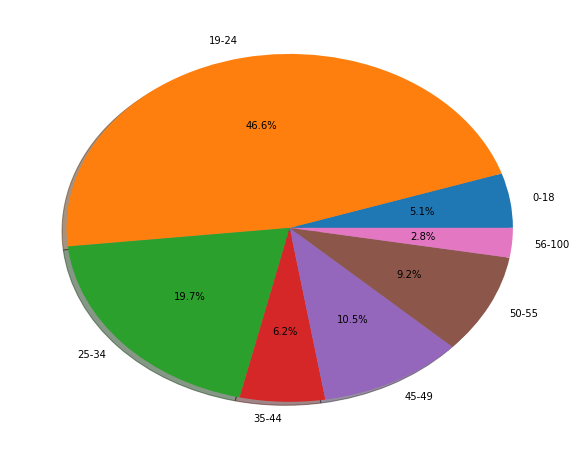

In [17]:
labels=age_distribution.keys()
fracs=age_distribution.values()
fig_size=[0,0]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

In [18]:
gender_distribution

{'male': 642, 'female': 282}

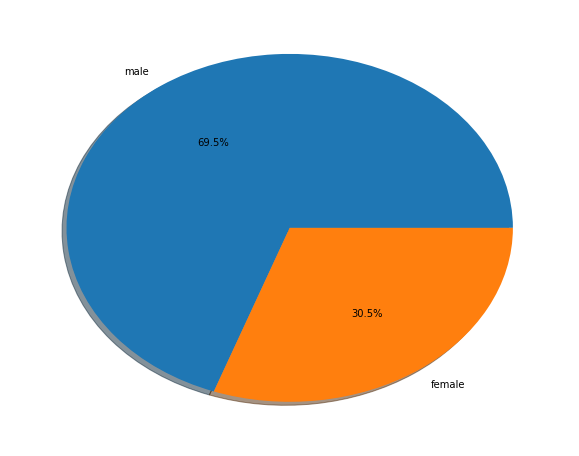

In [19]:
labels=gender_distribution.keys()
fracs=gender_distribution.values()
fig_size=[0,0]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

In [20]:
genre_distribution

{'Biography': 63,
 'Drama': 1681,
 'Thriller': 201,
 'Crime': 216,
 'Musical': 208,
 'Romance': 468,
 'Comedy': 464,
 'Adventure': 71,
 'Action': 306,
 'History': 70,
 'Sci-Fi': 8,
 'Sport': 21,
 'Fantasy': 38,
 'Mystery': 90,
 'Music': 18,
 'Family': 214,
 'War': 33,
 'Horror': 22,
 'Animation': 6,
 'Western': 1,
 'News': 1,
 'Romace': 1}

<BarContainer object of 22 artists>

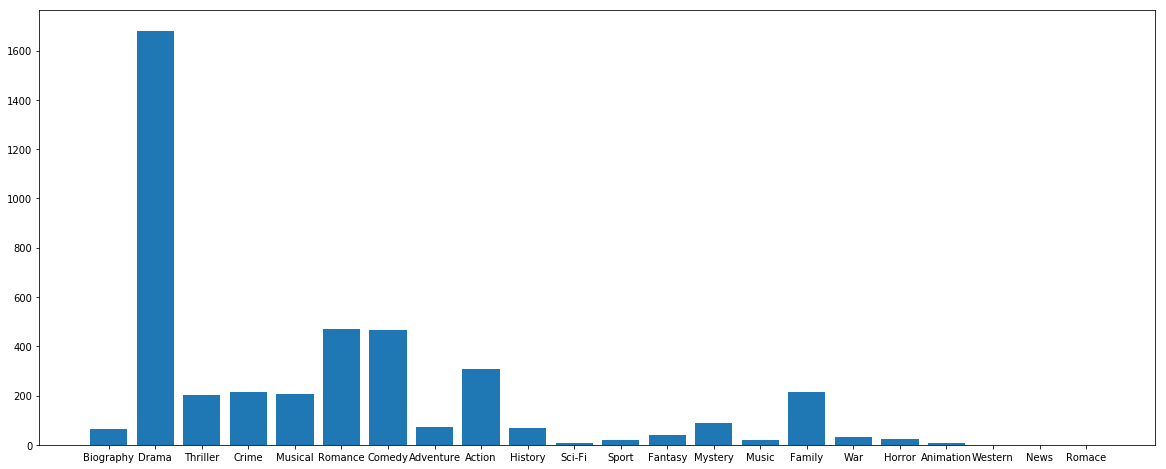

In [21]:
lab=genre_distribution.keys()
fracs=genre_distribution.values()
fig_size=[0,0]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.bar(lab,fracs)

In [22]:
state_distribution

{'Haryana': 30,
 'Delhi': 637,
 'Jharkhand': 2,
 'Andhra Pradesh': 65,
 'Uttarakhand': 5,
 'Uttar Pradesh': 63,
 'Rajasthan': 13,
 'Jammu & Kashmir': 4,
 'Bihar': 8,
 'Punjab': 12,
 'Chhattisgarh': 6,
 'Odisha': 2,
 'Maharashtra': 23,
 'Nagaland': 1,
 'Arunachal Pradesh': 1,
 'Assam': 4,
 'Goa': 2,
 'Madhya Pradesh': 7,
 'Karnataka': 8,
 'Kerala': 6,
 'Himachal Pradesh': 5,
 'Gujarat': 1,
 'Tamil Nadu': 7,
 'West Bengal': 6,
 'Telangana': 3,
 'Meghalaya': 1,
 'Tripura': 1}

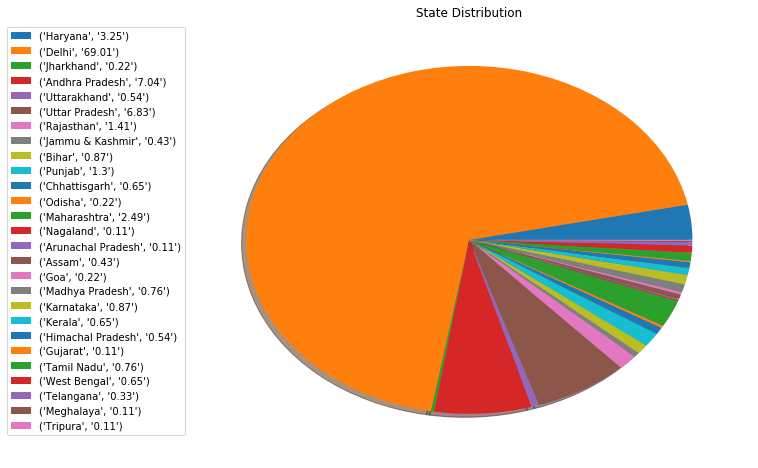

In [23]:
lab=state_distribution.keys()
fracs=state_distribution.values()
temp=sum(fracs)
per=[str(round((i/temp*100),2)) for i in fracs]
fig_size=[0,0]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
result = plt.pie(fracs, labels=None, shadow=True)
plt.title("State Distribution")
plt.legend(result[0],zip(lab,per),bbox_to_anchor=(0.00, 1))
plt.show()

In [24]:
lang_distribution

{'Hindi': 704,
 'Panjabi': 150,
 'English': 194,
 'Urdu': 129,
 'Gujarati': 49,
 'Awadhi': 3,
 'Mandarin': 9,
 'Japanese': 8,
 'Shanghainese': 1,
 'Cantonese': 2,
 'Arabic': 9,
 'Malayalam': 346,
 'French': 14,
 'Spanish': 4,
 'Tamil': 314,
 'Chinese': 4,
 'Bengali': 582,
 'Danish': 1,
 'Swedish': 2,
 'Sanskrit': 13,
 'Dutch': 1,
 'Marathi': 203,
 'Telugu': 338,
 'Thai': 2,
 'Portuguese': 4,
 'Pushto': 5,
 'Hungarian': 2,
 'Tibetan': 1,
 'Ladakhi': 2,
 'Assamese': 22,
 'Bhojpuri': 26,
 'Chhattisgarhi': 2,
 'Indian Sign Language': 2,
 'Konkani': 6,
 'Malay': 7,
 'Hokkien': 1,
 'German': 6,
 'Hebrew': 1,
 'Nepali': 51,
 'Oriya': 98,
 'Rajasthani': 18,
 'Dari': 2,
 'Russian': 6,
 'Turkish': 2,
 'Ukrainian': 1,
 'Persian': 3,
 'Indonesian': 1,
 'Italian': 2,
 'Greek': 1,
 'Romanian': 2,
 'Filipino': 1,
 'Kannada': 305,
 'Tagalog': 1,
 'Tulu': 2,
 'Kazakh': 1,
 'Berber languages': 1,
 'Sindhi': 4,
 'Swahili': 1,
 'Haryanvi': 3,
 'Manipuri': 8,
 'Sinhalese': 3,
 'Latin': 1,
 'Armenian': 1}

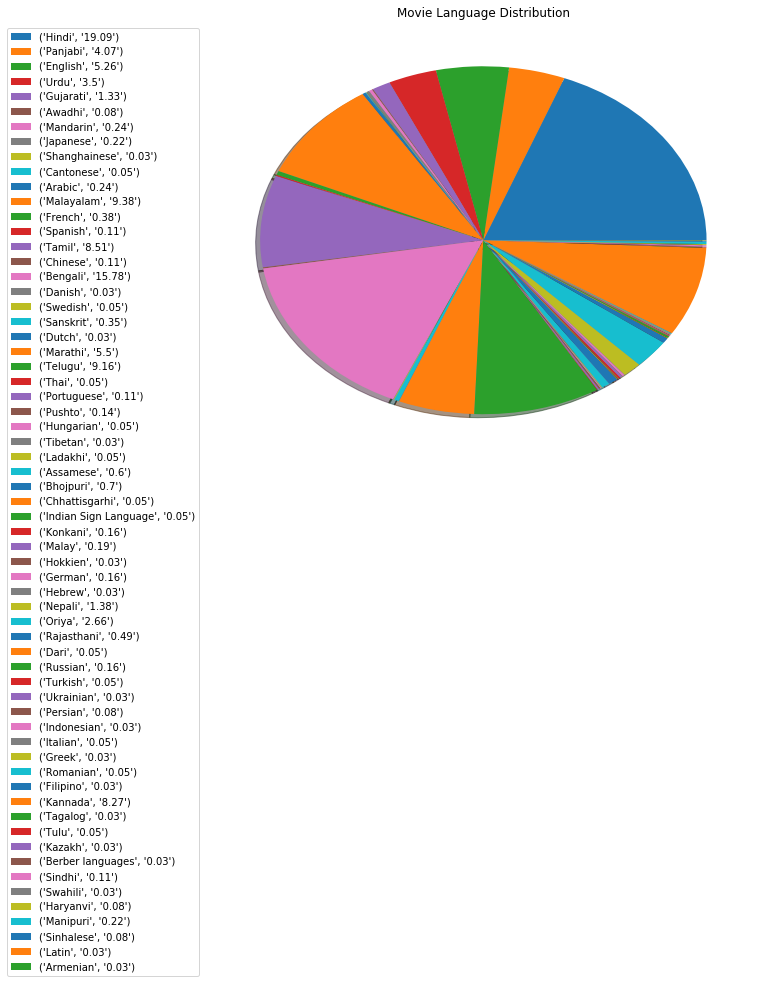

In [25]:
lab=lang_distribution.keys()
fracs=lang_distribution.values()
temp=sum(fracs)
per=[str(round((i/temp*100),2)) for i in fracs]
fig_size=[0,0]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
result = plt.pie(fracs, labels=None, shadow=True)
plt.title("Movie Language Distribution")
plt.legend(result[0],zip(lab,per),bbox_to_anchor=(0.00, 1))
plt.show()

In [26]:
language_distribution

{'Hindi': 908,
 'Bengali': 29,
 'Urdu': 24,
 'Bhojpuri': 22,
 'Rajasthani': 14,
 'Punjabi': 79,
 'Tamil': 30,
 'Telugu': 18,
 'Kannada': 11,
 'Malayalam': 16,
 'Gujarati': 7,
 'Haryanvi': 18,
 'Marathi': 14,
 'Konkani': 4,
 'Manipuri': 4,
 'Oriya': 6,
 'Nepali': 9,
 'Assamese': 10}

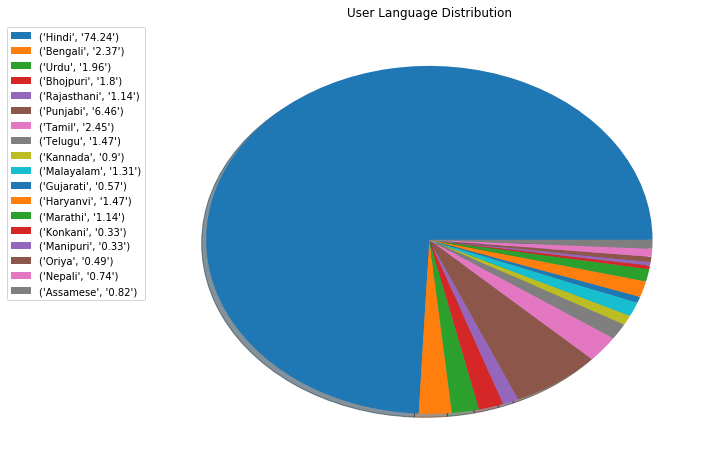

In [27]:
lab=language_distribution.keys()
fracs=language_distribution.values()
temp=sum(fracs)
per=[str(round((i/temp*100),2)) for i in fracs]
fig_size=[0,0]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
result = plt.pie(fracs, labels=None, shadow=True)
plt.title("User Language Distribution")
plt.legend(result[0],zip(lab,per),bbox_to_anchor=(0.00, 1))
plt.show()

In [28]:
trained_model

[(0, 5.627452340056462),
 (1, 5.18449651709984),
 (2, 4.460677107984205),
 (3, 3.3303051586644092),
 (4, 2.1410819343099887),
 (5, 1.3922005979993335),
 (6, 0.9478616819223761),
 (7, 0.6537718570468755),
 (8, 0.4558561333912059),
 (9, 0.32751650602258686),
 (10, 0.2343198965573934),
 (11, 0.16878618273426113),
 (12, 0.1226351859775641),
 (13, 0.09024250385150803),
 (14, 0.07197571067144788),
 (15, 0.05815068661046417),
 (16, 0.050906744382789415),
 (17, 0.046431538668447604),
 (18, 0.04222526709703279),
 (19, 0.040528783027630425),
 (20, 0.04088358470041263),
 (21, 0.039654627962245836),
 (22, 0.038767064937105196),
 (23, 0.04002065877123585),
 (24, 0.0409891672910334),
 (25, 0.040459214930610984),
 (26, 0.03991730116545806),
 (27, 0.04110646044940188),
 (28, 0.040741782418627755),
 (29, 0.03803804872335164),
 (30, 0.037691883113631725),
 (31, 0.036637400356275024),
 (32, 0.03731380290981084),
 (33, 0.03780448236759074),
 (34, 0.039169639775685355),
 (35, 0.03930320577250699),
 (36, 0.

Text(0.5,1,'NMF')

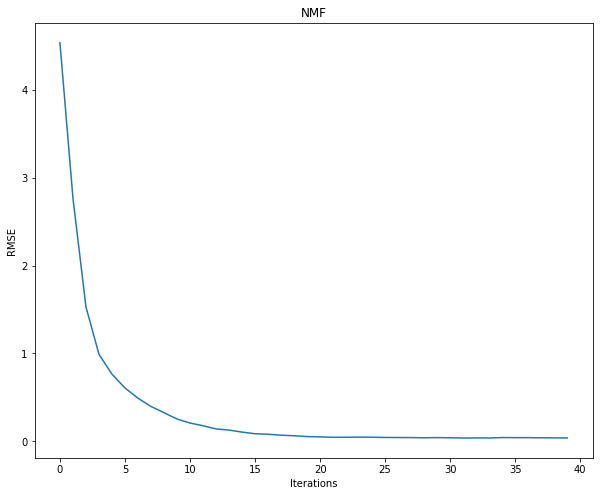

In [38]:
x=[i[0] for i in trained_model]
y=[i[1] for i in trained_model]
plt.plot(x,y)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("NMF")